In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)




Mounted at /content/drive


In [ ]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.metrics import structural_similarity as ssim
import tensorflow as tf
from skimage import img_as_float
import random

In [ ]:
# Function to calculate Mean Squared Error (MSE)
def calculate_mse(original, processed):
    return np.mean((original - processed) ** 2)

# Function to calculate Peak Signal-to-Noise Ratio (PSNR)
def calculate_psnr(original, processed):
    mse = calculate_mse(original, processed)
    if mse == 0:
        return float('inf')  # If the images are identical
    max_pixel = 255.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))

# Function to generate a random color
def get_random_color():
    return (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))


In [ ]:
# Load YOLOv3 configuration and weights
net = cv2.dnn.readNet('/content/drive/My Drive/ImageProcessing/yolov3.weights', '/content/drive/My Drive/ImageProcessing/yolov3.cfg')

# Get output layer names
layer_names = net.getLayerNames()
output_layers_indices = net.getUnconnectedOutLayers()

# Ensure output_layers_indices is iterable
if isinstance(output_layers_indices, int):  # If it's a scalar, wrap it in a list
    output_layers_indices = [output_layers_indices]

# Get the names of the output layers
output_layers = [layer_names[i - 1] for i in output_layers_indices] # Adjusted to directly use the index


In [ ]:
# Frequency filter function
def frequency_filters(image_rgb):
    def apply_frequency_filter(img_channel, radius=30):
        dft = np.fft.fft2(img_channel)
        dft_shifted = np.fft.fftshift(dft)
        rows, cols = img_channel.shape
        crow, ccol = rows // 2 , cols // 2
        x, y = np.meshgrid(np.linspace(-1, 1, cols), np.linspace(-1, 1, rows))
        d = np.sqrt(x*x + y*y)
        gaussian_highpass = 1 - np.exp(-((d**2) / (2.0 * (radius**2))))
        filtered_dft_shifted = dft_shifted * gaussian_highpass
        filtered_dft = np.fft.ifftshift(filtered_dft_shifted)
        img_back = np.fft.ifft2(filtered_dft)
        img_back = np.abs(img_back)
        img_back = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX)
        return np.uint8(img_back)

    channels = cv2.split(image_rgb)
    filtered_channels = [apply_frequency_filter(channel) for channel in channels]
    enhanced_channels = []
    for orig_channel, filtered_channel in zip(channels, filtered_channels):
        equalized_orig_channel = cv2.equalizeHist(orig_channel)
        enhanced_channel = cv2.addWeighted(equalized_orig_channel, 0.8, filtered_channel, 0.2, 0)
        enhanced_channels.append(enhanced_channel)
    enhanced_image = cv2.merge(enhanced_channels)
    return enhanced_image


In [ ]:
# Color correction function
def apply_color_correction(image):
    result = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    avg_a = np.mean(result[:, :, 1])
    avg_b = np.mean(result[:, :, 2])
    result[:, :, 1] = result[:, :, 1] - avg_a + 128
    result[:, :, 2] = result[:, :, 2] - avg_b + 128
    corrected_img = cv2.cvtColor(result, cv2.COLOR_LAB2RGB)
    return corrected_img

# Unsharp mask function
def apply_unsharp_mask(image):
    gaussian_blur = cv2.GaussianBlur(image, (0, 0), sigmaX=2, sigmaY=2)
    unsharp_mask = cv2.addWeighted(image, 1.5, gaussian_blur, -0.5, 0)
    return unsharp_mask


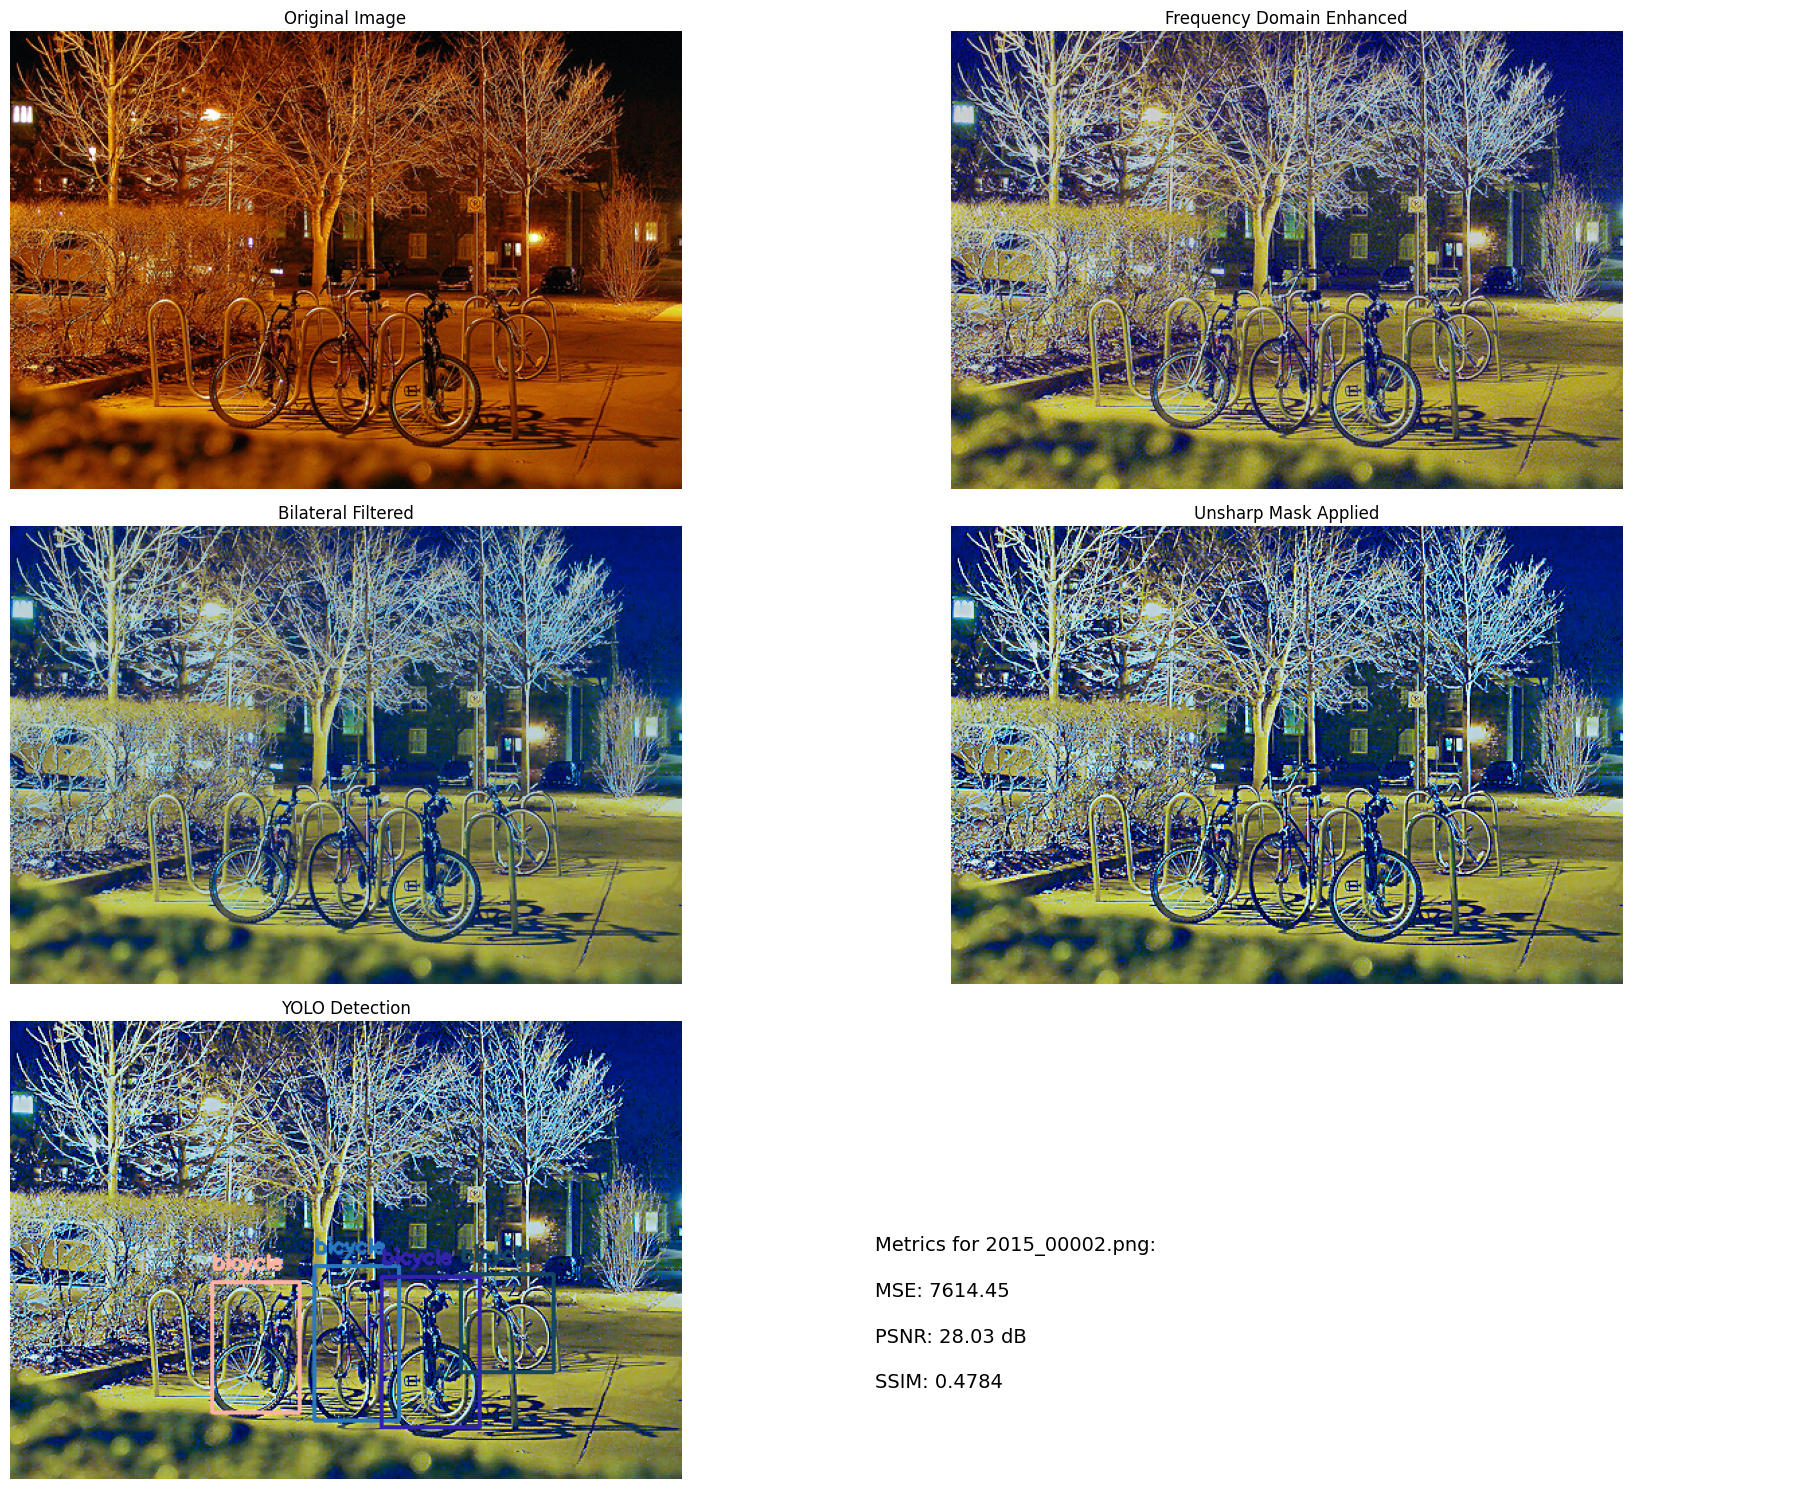

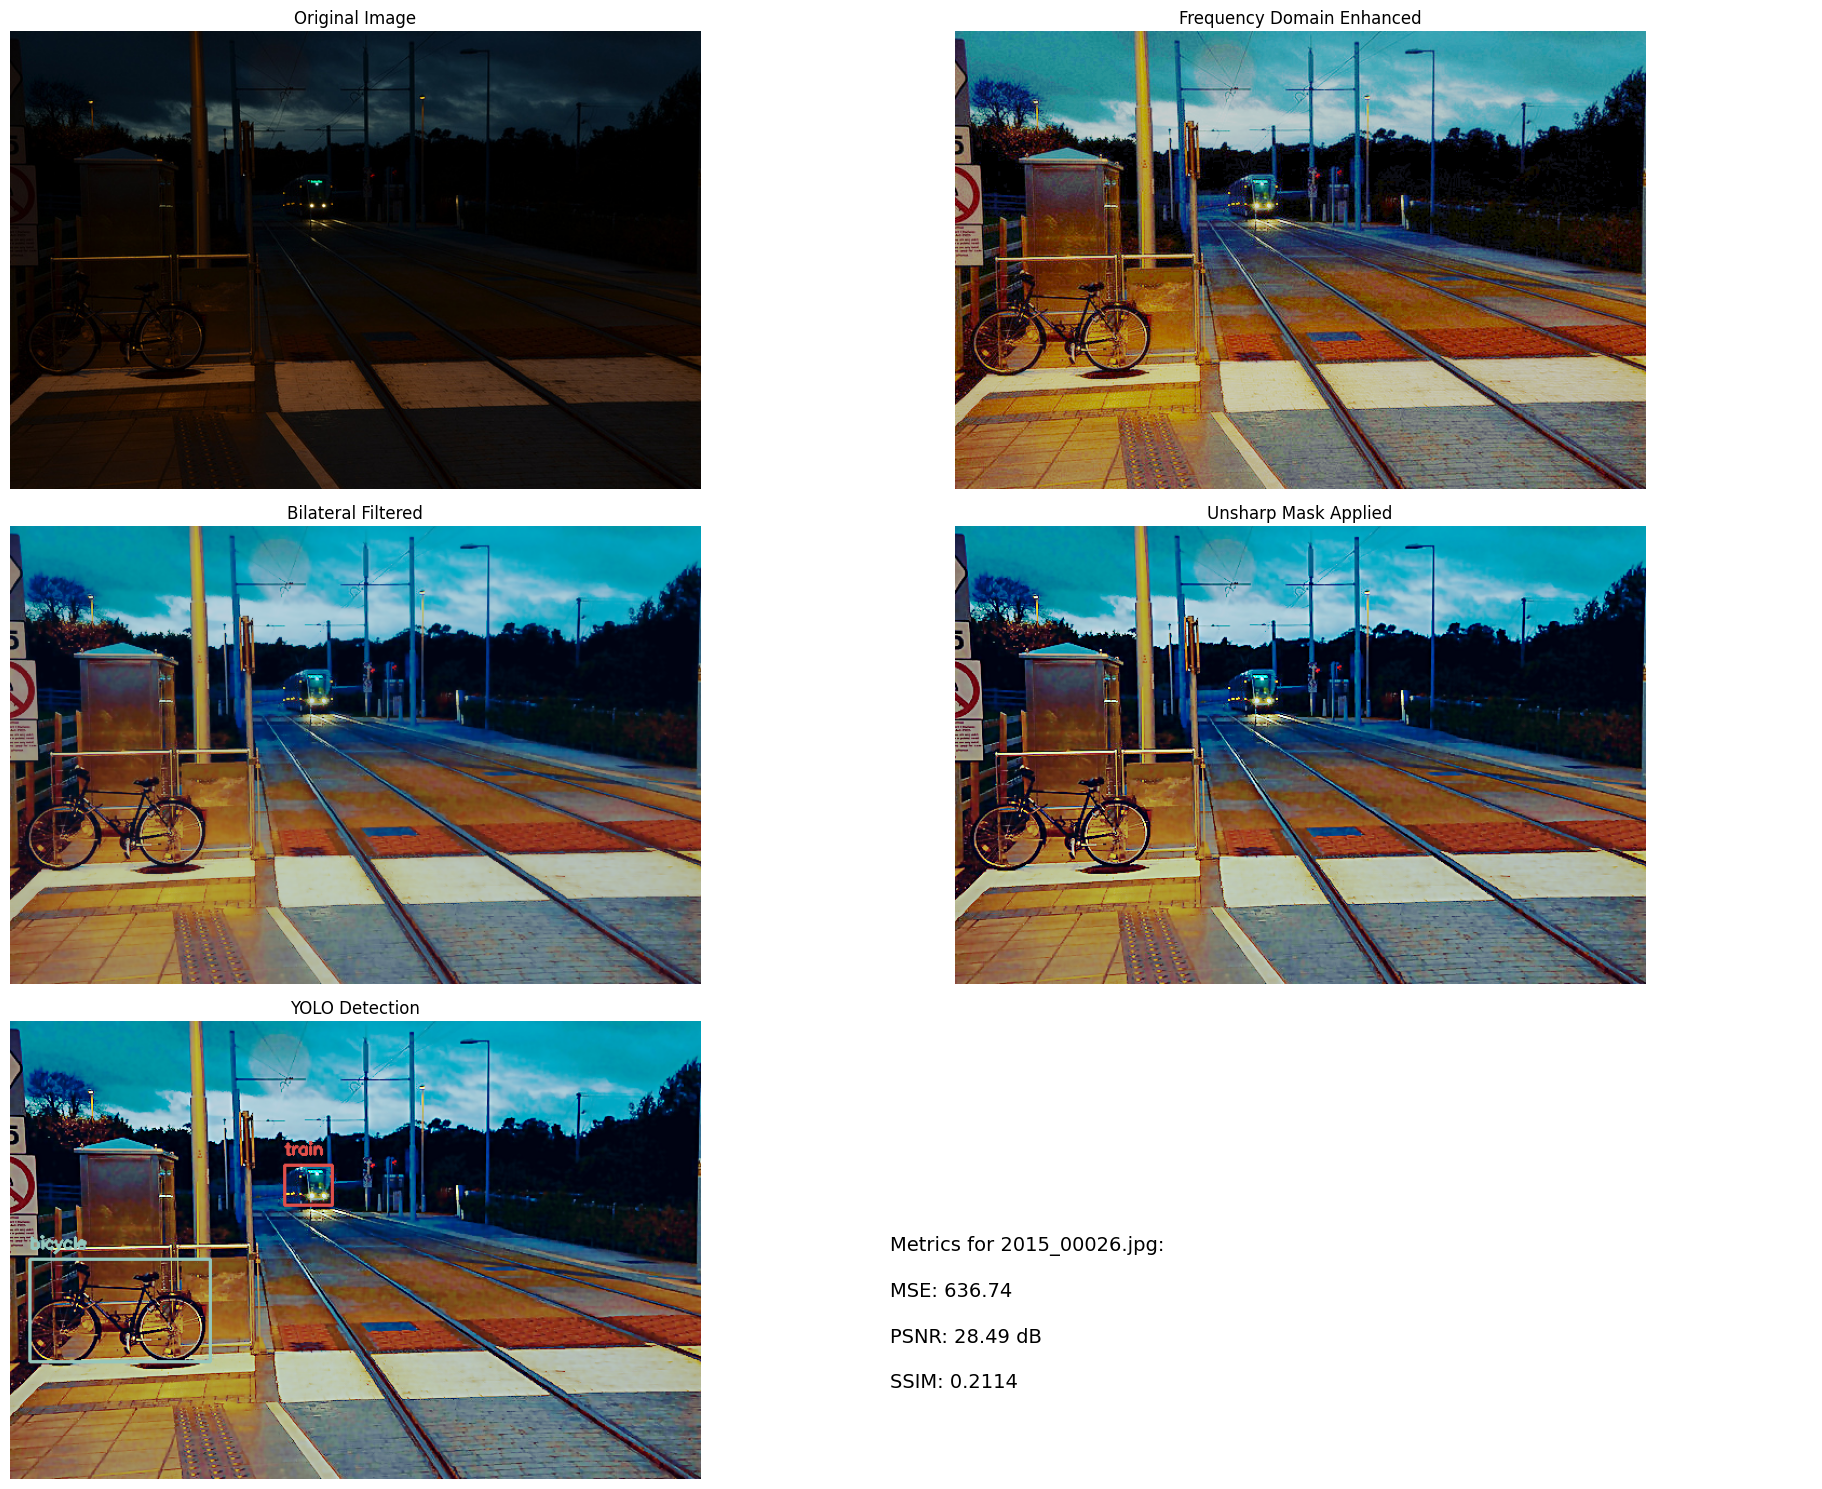

In [ ]:
# Define the dataset path and number of images to process
dataset_path = "/content/drive/MyDrive/ImageProcessing/Dataset/Main"
no_of_images = 2
image_filenames = sorted(os.listdir(dataset_path))[:no_of_images]

# Process each image
for img_name in image_filenames:
    img_path = os.path.join(dataset_path, img_name)
    image = cv2.imread(img_path)
    if image is None:
        print(f"Failed to load image: {img_path}")
        continue

    # Convert from BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    enhanced_image = frequency_filters(image_rgb)

    # Apply color correction, bilateral filter, and unsharp mask
    img_color_corrected = apply_color_correction(enhanced_image)
    img_bilateral_filtered = cv2.bilateralFilter(img_color_corrected, d=5, sigmaColor=50, sigmaSpace=50)
    img_unsharp_masked = apply_unsharp_mask(img_bilateral_filtered)

    # ------------ OBJECT DETECTION USING YOLO ----------------
    yolo_image = img_unsharp_masked.copy()
    height, width, channels = yolo_image.shape
    blob = cv2.dnn.blobFromImage(yolo_image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    # Load class names
    with open('/content/drive/MyDrive/ImageProcessing/coco.names', 'r') as f:
        classes = [line.strip() for line in f.readlines()]

    class_ids = []
    confidences = []
    boxes = []
    colors = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
                colors.append(get_random_color())

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = colors[i]
            cv2.rectangle(yolo_image, (x, y), (x + w, y + h), color, 2)
            cv2.putText(yolo_image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # ------------ Display All Images and Metrics in a Single Plot ------------
    plt.figure(figsize=(20, 15))

    # Display original, enhanced, and processed images
    plt.subplot(3, 2, 1)
    plt.imshow(image_rgb)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(3, 2, 2)
    plt.imshow(enhanced_image)
    plt.title("Frequency Domain Enhanced")
    plt.axis('off')

    plt.subplot(3, 2, 3)
    plt.imshow(img_bilateral_filtered)
    plt.title("Bilateral Filtered")
    plt.axis('off')

    plt.subplot(3, 2, 4)
    plt.imshow(img_unsharp_masked)
    plt.title("Unsharp Mask Applied")
    plt.axis('off')

    plt.subplot(3, 2, 5)
    plt.imshow(yolo_image)
    plt.title("YOLO Detection")
    plt.axis('off')

    # Calculate performance metrics
    mse_value = calculate_mse(image_rgb, img_as_float(yolo_image))
    psnr_value = calculate_psnr(image_rgb, yolo_image)
    ssim_value = ssim(image_rgb, yolo_image, win_size=min(7, min(image_rgb.shape[:2])), channel_axis=2)

    # Add metrics to the plot
    plt.subplot(3, 2, 6)
    plt.text(0.1, 0.5, f"Metrics for {img_name}:", fontsize=14)
    plt.text(0.1, 0.4, f"MSE: {mse_value:.2f}", fontsize=14)
    plt.text(0.1, 0.3, f"PSNR: {psnr_value:.2f} dB", fontsize=14)
    plt.text(0.1, 0.2, f"SSIM: {ssim_value:.4f}", fontsize=14)
    plt.axis('off')

    plt.tight_layout()
    plt.show()